# Does Geographical Location Affect Cabernet Sauvignon Wine Ratings?

# Introduction

Grown in nearly every major wine producing country, Cabernet Sauvignon is one of the world’s most widely recognized red wine grape varieties (Muñoz, Flavio, et al., 2021). From Australia’s Hunter Valley to Canada’s British Columbia to Lebanon’s Beqaa Valley, these diverse climates accentuate different flavour profiles of the Cabernet Sauvignon grape in wine.

For example, in cooler climates, Cabernet Sauvignon wines have blackcurrant notes that can be accompanied by green bell pepper notes, mint and cedar which will all become more pronounced as the wine ages. While in more moderate climates, the black currant notes are often seen with black cherry and black olive notes; and in very hot climates, the currant flavors can veer towards the over-ripe and "jammy" side.

Therefore, we can see that location plays an important role in a wine’s quality. Better known by the French word, terroir is composed of three characteristics, soil, climate, and cultivar, which dictate wine quality (Lock, Peter, et al., 2019). These characteristics yield a multitude of chemical and sensory personalities; and, more notably, can significantly affect the quality of Cabernet Sauvignon wines (Muñoz, Flavio, et al., 2021).

Understanding a grape’s personality is fundamental, and knowing if the geographical location in which grapes are grown can affect sommeliers’ blind tasting is one of the essences of appreciating wine. We would like to explore how the appellations determine which grapes excel in wine ratings. This leads to the question: how does growing Cabernet Sauvignon grapes in Napa Valley and Columbia Valley affect its wine ratings? We’ll focus on the data scraped from WineEnthusiast during the week of June 15th, 2017 to study the influence of these two regions towards wine ratings. Additionally, we will be examining and comparing at the mean ratings and their standard deviations for each region to determine the average rating and its variability. **(EXPLAIN WHY WE CHOSE THESE SCALE PARAMETERS).*** 


# Methods and Results

In [37]:
library(cowplot)
library(tidyverse)
library(dplyr)
library(digest)
library(infer)
library(repr)
library(broom)

We first load the downloaded data set from Kaggle's open data set. Then, we tidy the data set by filtering to see only wines made from the Cabernet Sauvignon grape in Napa Valley or Columbia Valley, and selecting the columns relevant to our study: the region the grape was grown in (ie: Napa Valley or Columbia Valley) and the rating/points the wine received on a scale of 0-100.

In [2]:
cs_wine <- read_csv("winemag-data_first150k.csv") %>%
            rename(region = region_1) %>%
            filter(variety == "Cabernet Sauvignon", region == "Napa Valley" | region == "Columbia Valley (WA)") %>%
            select(points, region)

"Table 1: The Data Set"
head(cs_wine)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  country = col_character(),
  description = col_character(),
  designation = col_character(),
  points = col_double(),
  price = col_double(),
  province = col_character(),
  region_1 = col_character(),
  region_2 = col_character(),
  variety = col_character(),
  winery = col_character()
)



[1] "Table 1: The Data Set"

points,region
<dbl>,<chr>
96,Napa Valley
91,Napa Valley
91,Napa Valley
91,Napa Valley
86,Napa Valley
90,Napa Valley


## Preliminary Results

Now, we calculate the mean for both regions, and plot the distributions, with a line indicating their respective sample mean, for easier visualization of the distribution of points. The sample size for each region is included, for reference.

In [3]:
mean_dist <- cs_wine %>%
                group_by(region) %>%
                summarize(sample_mean = mean(points),
                          n = n())

"Table 2: Mean and Sample Size for Each Region"
head(mean_dist)

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 2: Mean and Sample Size for Each Region"

region,sample_mean,n
<chr>,<dbl>,<int>
Columbia Valley (WA),89.22585,766
Napa Valley,89.26661,2513


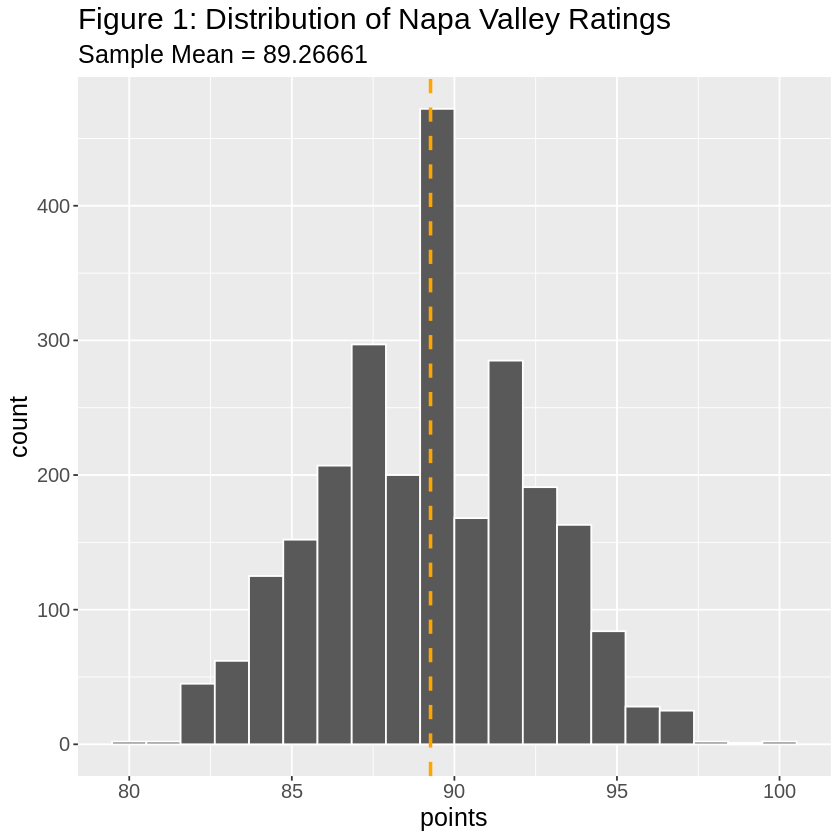

In [27]:
# Napa Valley plot
nv_plot <- cs_wine %>%
        filter(region == "Napa Valley") %>%
        ggplot() +
        geom_histogram(aes(x = points), colour = "white", bins = 20) +
        geom_vline(aes(xintercept = mean_dist$sample_mean[2]), color = "orange", linetype = "dashed", size = 1) +
        labs(title = "Figure 1: Distribution of Napa Valley Ratings",
             subtitle = "Sample Mean = 89.26661") +
        theme(text = element_text(size = 15))
        
nv_plot

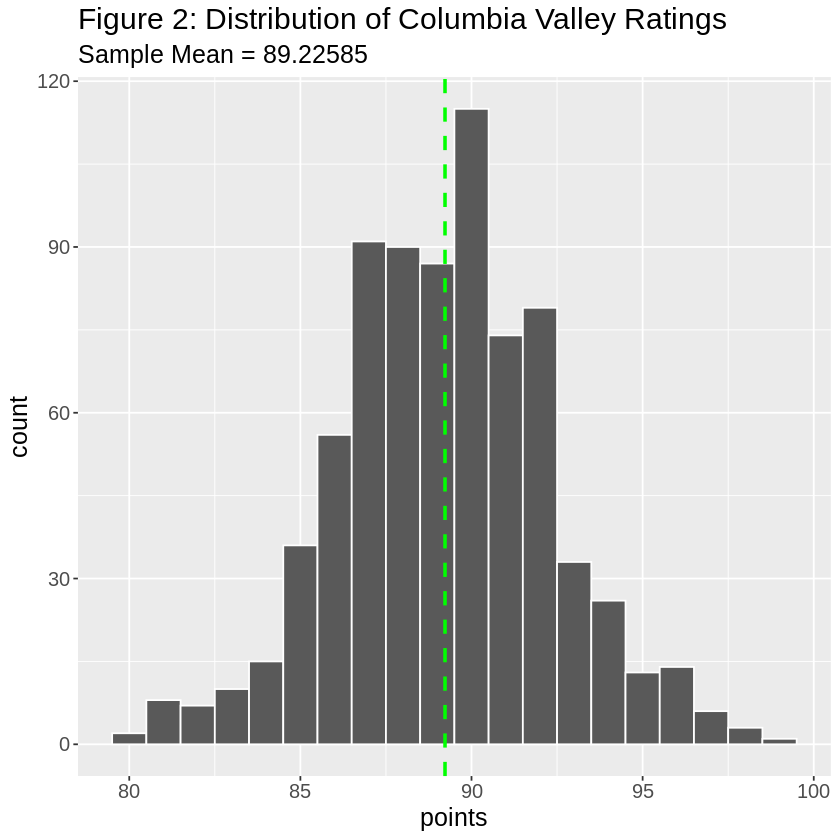

In [28]:
# Columbia Valley plot
cv_plot <- cs_wine %>%
        filter(region == "Columbia Valley (WA)") %>%
        ggplot() +
        geom_histogram(aes(x = points), colour = "white", bins = 20) +
        geom_vline(aes(xintercept = mean_dist$sample_mean[1]), color = "green", linetype = "dashed", size = 1) +
        labs(title = "Figure 2: Distribution of Columbia Valley Ratings",
             subtitle = "Sample Mean = 89.22585") +
        theme(text = element_text(size = 15))
cv_plot

## Hypothesis Testing

To determine whether or not Cabernet Sauvignon grapes grown in Napa Valley and Columbia Valley affect wine ratings, we will conduct a hypothesis test. Namely, the test's null hypothesis will be $H_0: \mu_1 = \mu_2$, where $\mu_1$ is the mean of the points received for grapes grown in Napa Valley and $\mu_2$ is that of Columbia Valley. And our alternative hypothesis is $H_1: \mu_1 \neq \mu_2$. 

Using a 5% significance level (ie: 95% confidence level), we will be employing two different methods of hypothesis testing: bootstrapping and using the CLT. 

### Bootstrapped Distribution

First, we calculate the observed test statistic, the difference in means, which will be used to calculate the $p$-value. Additionally, the test statistic also serves as evidence as to whether or not to reject the null hypothesis.

In [6]:
obs_diff <- cs_wine %>%
        specify(formula = points ~ region) %>%
        calculate(stat = "diff in means", order = c("Napa Valley", "Columbia Valley (WA)")) 

"Table 3: Observed Test Statistic - Difference in Means"
obs_diff

[1] "Table 3: Observed Test Statistic - Difference in Means"

stat
<dbl>
0.04076505


In the bootstrapped distribution, we generate 1000 samples from the null distribution and calculate each samples' difference in means. From that, we can also calculate the 95% confidence interval and $p$-value. Finally, to visualize, we can display the distribution with the shaded confidence interval and the $p$-value with the shaded tails.

In [50]:
set.seed(2021)

bootstrap_dist <- cs_wine %>%
                specify(formula = points ~ region) %>%
                hypothesize(null = "independence") %>%
                generate(reps = 1000, type = "permute") %>%
                calculate(stat = "diff in means", order = c("Napa Valley", "Columbia Valley (WA)"))

boot_p_value <- bootstrap_dist %>%
        get_p_value(obs_stat = obs_diff, direction = "both")

boot_ci <- bootstrap_dist %>%
    get_confidence_interval(level = 0.95, type = "percentile")

boot_summary <- tibble(boot_ci, boot_p_value)
"Table 4: Bounds of 95% Confidence Interval and p-value of the Bootstrapped Distribution"
boot_summary

[1] "Table 4: Bounds of 95% Confidence Interval and p-value of the Bootstrapped Distribution"

lower_ci,upper_ci,p_value
<dbl>,<dbl>,<dbl>
-0.2727057,0.2741327,0.762


Here, we visualize the confidence intervals and $p$-value (tail shading) in separate graphs.

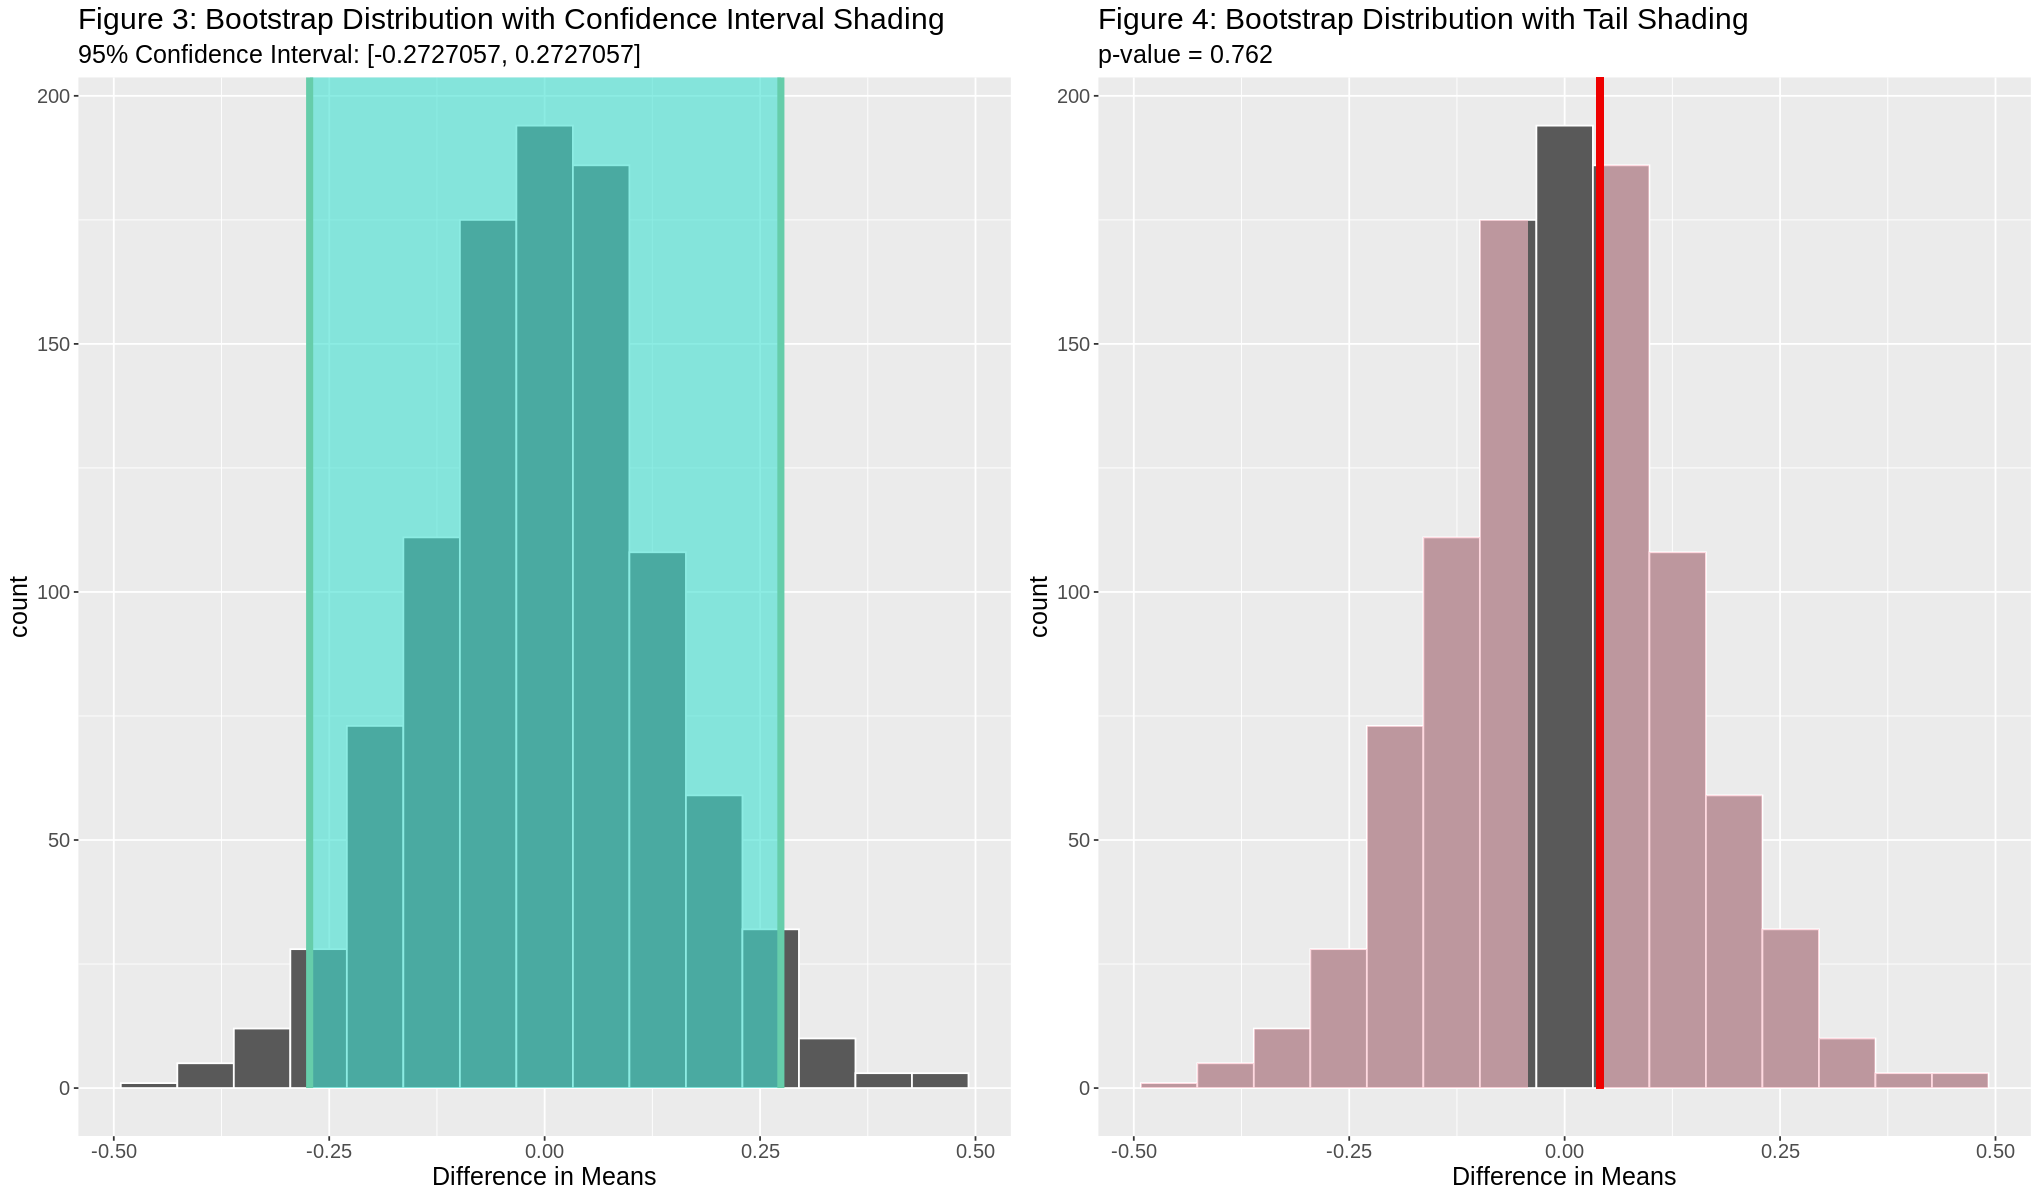

In [54]:
options(repr.plot.width = 17, repr.plot.height = 10)

# Confidence interval shading plot
ci_plot <- visualize(bootstrap_dist) + 
        shade_confidence_interval(endpoints = boot_ci) +
        labs(title = "Figure 3: Bootstrap Distribution with Confidence Interval Shading",
             subtitle = "95% Confidence Interval: [-0.2727057, 0.2727057]",
             x = "Difference in Means") +
        theme(text = element_text(size = 15))

# p-value/tail shading plot
p_val_plot <- visualize(bootstrap_dist) + 
        shade_p_value(obs_stat = obs_diff, direction = "both") +
        labs(title = "Figure 4: Bootstrap Distribution with Tail Shading",
             subtitle = "p-value = 0.762",
             x = "Difference in Means") +
        theme(text = element_text(size = 15))

plot_grid(ci_plot, p_val_plot)

With a 95% confidence level, we get a confidence interval of $[-0.2727057, 0.2727057]$, which means that true population difference in means will fall in that interval 95% of the time. And obtaining a $p$-value of $0.762$ means that we are unlikely to observe a difference in means, as depicted in Figure 4.

Finally, given that the $p$-value of $0.762$ is greater than 0.05, we do not have enough evidence to reject the null hypothesis, $H_0$.

### CLT Distribution

To conduct the t-test for the CLT, we separate the data into two different groups: Napa Valley points and Columbia Valley points. Then, we compare the two groups against each other in the `t.test` function.

In [52]:
# Grouping
napa <- cs_wine %>%
        filter(region == "Napa Valley") %>%
        pull(points)

columbia <- cs_wine %>%
            filter(region == "Columbia Valley (WA)") %>%
            pull(points)

# T-test
t_test <- tidy(t.test(x = napa, 
                      y = columbia))

"Table 5: T-test Summary"
t_test

[1] "Table 5: T-test Summary"

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.04076505,89.26661,89.22585,0.308029,0.7581061,1398.418,-0.2188444,0.3003745,Welch Two Sample t-test,two.sided


From the table, we can see that the $p$-value is $0.7581061$, which is, again, greater than 0.05. Therefore, using CLT/t-test, we fail to reject the null hypothesis $H_0$.

### Bootstrap vs. CLT 

Due to our large sample size of 3279, using the CLT is more appropriate as bootstrapping 1000 replicates of that size is computationally expensive. With that being said, both methods gave very similar results. Some possible reasons why the bootstrap method produced similar results to the CLT are: the large sample size and doing 1000 repetitions. A large sample size allows narrower confidence intervals; and choosing 1000 repetitions tends to produce a good sense of how the statistic behaves, therefore resulting in a pretty accurate sampling distribution. 

All in all, both methods of hypothesis testing are trustworthy as they produced very similar results. And the slight difference in results can be negligible, since it is so small. 

# Discussion

# References

Lock, Peter, et al., "Wineries and wine quality: The influence of location and archetype in the Hunter Valley region in Australia." _Wine Economics and Policy_, vol. 8, issue 2, 2019, 180-190, doi.org/10.1016/j.wep.2019.10.002. Accessed 1 Aug. 2021.

Muñoz, Flavio, et al. “Phenolic Characterization of Cabernet Sauvignon Wines From Different Geographical   Indications of Mendoza, Argentina: Effects of Plant Material and Environment.” _Frontiers in Sustainable Food Systems_, vol. 5, 2021, doi:10.3389/fsufs.2021.700642. Accessed 1 Aug. 2021.

Thoutt, Zack. "Wine Reviews" (Version 4), _Kaggle_, 27 Nov. 2017. https://www.kaggle.com/zynicide/wine-reviews. Accessed 1 Aug. 2021.